## 1.   Config environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/Othercomputers/PC/msc_final_project/TPU/attack/whitebox/I_FSGM/Colab')

In [ ]:
import tensorflow as tf

# cifar10
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [ ]:
# Importing models and compiling them
#model = tf.keras.models.load_model('../../../build/saved_model/ResNet_TransferLearning/HDF5/ResNet_TransferLearning.h5', compile=True)
#model = tf.keras.models.load_model('../../../../build/saved_model/Simple_CNN/HDF5/Simple_CN.h5', compile=True)
model = tf.keras.models.load_model('../../../../build/saved_model/ResNet_TransferLearning/HDF5/ResNet_TransferLearning.h5', compile=True)

# Show the model architecture
#model.summary()



## 1    Preparing and pre-processing data

In [ ]:
# Utility functions
def print_shapes(train_images, test_images, train_labels, test_labels):
  print(f"train_images: {train_images.shape}\n"\
      f"test_images: {test_images.shape}\n"\
      f"train_labels: {train_labels.shape}\n"\
      f"test_labels: {test_labels.shape}\n")

In [ ]:
# loading the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
print_shapes(train_images, test_images, train_labels, test_labels)

170508288/170498071 [==============================] - 2s 0us/step
train_images: (50000, 32, 32, 3)
test_images: (10000, 32, 32, 3)
train_labels: (50000, 1)
test_labels: (10000, 1)



In [ ]:
# Preprocessing images and labels
height, width, channels = 32, 32, 3
nb_classes = 10 
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

train_images = train_images / 255
test_images = test_images / 255

train_images = train_images.reshape((-1, height, width, channels))
test_images = test_images.reshape((-1, height, width, channels))

train_labels = tf.keras.utils.to_categorical(train_labels, nb_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, nb_classes)

print_shapes(train_images, test_images, train_labels, test_labels)

train_images: (50000, 32, 32, 3)
test_images: (10000, 32, 32, 3)
train_labels: (50000, 10)
test_labels: (10000, 10)



## 2.    Implementing the I-FGSM Method with Keras and TensorFlow

In [ ]:
# Function to calculate adversary noise
def generate_adversary(image, label):
  '''Generates adversarial noise for a given image and label
  Args:
    image(np.array):  input image, shape like (1, height, width, channels)
    label(int): label of the image, shape like (nb_classes, )
  
  Returns:
    sign_grad(tf.Tensor): adversarial noise, should be changed to numpy array before add to the image.T
                          shape like (1, height, width, channels)
  '''

  # Change the image to a tensor
  image = tf.cast(image, tf.float32)

  #record gradients
  with tf.GradientTape() as tape:

    tape.watch(image)

    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
    
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)

  return sign_grad

In [ ]:
def I_FSGM(image, label, alpha, epsilon):
    '''Performs I-FSGM attack on a given image and label
    Formula:
        X_0_adv = X
        X_N+1_adv = Clip(X_N_adv + alpha * sign(grad(X_N_adv, Y_true)))
        alpha selected from 1
        iterations to be min(epsilon+4, 1.25 * epsilon)

    Args:
        image(np.array):  input image, shape like (height, width, channels)
        label(int): label of the image, shape like (nb_classes, )
        alpha(float): alpha parameter for I-FSGM
        epsilon(int): epsilon parameter for I-FSGM
    
    Examples:
        >>> tmp = I_FSGM(train_images[0], train_labels[0], 0.1, 5)
    
    Returns:
        adv_image(np.array): adversarial image, shape like (height, width, channels)
    '''

    image = image.reshape(1,32,32,3)
    
    for i in range(int(min(epsilon+4, 1.25 * epsilon))):

        # Generate adversarial noise
        # Because the original image is already between [0, 1], the resulting pixels are also divided by 255
        sign_grad = (generate_adversary(image, label) / 255).numpy()

        img_adv = (image + alpha * sign_grad).reshape(32,32,3)

        
        for j in range(len(img_adv)):
            for k in range(len(img_adv[j])):
                for l in range(len(img_adv[j][k])):

                    img_adv[j][k] = np.clip(img_adv[j][k] , image[0][j][k]  - epsilon/255, image[0][j][k]  + epsilon/255)
                
                    if img_adv[j][k][l] > 1:
                        img_adv[j][k][l] = 1
                    elif img_adv[j][k][l] < 0:
                        img_adv[j][k][l] = 0

        image = img_adv.reshape(1,32,32,3)

    return image.reshape(32,32,3)

In [ ]:
'''

def I_FSGM(image, label, alpha, epsilon):
    ''''''Performs I-FSGM attack on a given image and label
    Formula:
        X_0_adv = X
        X_N+1_adv = Clip(X_N_adv + alpha * sign(grad(X_N_adv, Y_true)))
        alpha selected from 1
        iterations to be min(epsilon+4, 1.25 * epsilon)

    Args:
        image(np.array):  input image, shape like (height, width, channels)
        label(int): label of the image, shape like (nb_classes, )
        alpha(float): alpha parameter for I-FSGM
        epsilon(int): epsilon parameter for I-FSGM
    
    Examples:
        >>> tmp = I_FSGM(train_images[0], train_labels[0], 0.1, 5)
    
    Returns:
        adv_image(np.array): adversarial image, shape like (height, width, channels)
    ''''''

    image = image.reshape(1,32,32,3)
    
    for i in range(int(min(epsilon+4, 1.25 * epsilon))):

        
        img_adv = (image + alpha * generate_adversary(image, label).numpy()).reshape(32,32,3)

        
        for j in range(len(img_adv)):
            for k in range(len(img_adv[j])):
                for l in range(len(img_adv[j][k])):

                    img_adv[j][k] = np.clip(img_adv[j][k] , image[0][j][k]  - epsilon/255, image[0][j][k]  + epsilon/255)
                
                    if img_adv[j][k][l] > 1:
                        img_adv[j][k][l] = 1
                    elif img_adv[j][k][l] < 0:
                        img_adv[j][k][l] = 0

        image = img_adv.reshape(1,32,32,3)

    return image.reshape(32,32,3)


'''

'\n\ndef I_FSGM(image, label, alpha, epsilon):\n    Performs I-FSGM attack on a given image and label\n    Formula:\n        X_0_adv = X\n        X_N+1_adv = Clip(X_N_adv + alpha * sign(grad(X_N_adv, Y_true)))\n        alpha selected from 1\n        iterations to be min(epsilon+4, 1.25 * epsilon)\n\n    Args:\n        image(np.array):  input image, shape like (height, width, channels)\n        label(int): label of the image, shape like (nb_classes, )\n        alpha(float): alpha parameter for I-FSGM\n        epsilon(int): epsilon parameter for I-FSGM\n    \n    Examples:\n        >>> tmp = I_FSGM(train_images[0], train_labels[0], 0.1, 5)\n    \n    Returns:\n        adv_image(np.array): adversarial image, shape like (height, width, channels)\n    \n\n    image = image.reshape(1,32,32,3)\n    \n    for i in range(int(min(epsilon+4, 1.25 * epsilon))):\n\n        \n        img_adv = (image + alpha * generate_adversary(image, label).numpy()).reshape(32,32,3)\n\n        \n        for j in r

## 3. Test Function and select different parameters

### 3.1 Use a sample to test the accuracy after attack and plot it

In [ ]:
index_tmp = random.randint(0, len(train_images)-1)

# used to generate adversarial image
image_test1 = train_images[index_tmp]
image_test1_label = train_labels[index_tmp]

# original input image
image_test2 = image_test1.copy()

In [ ]:
image_test1_adv = I_FSGM(image_test1, image_test1_label, 1, 5)

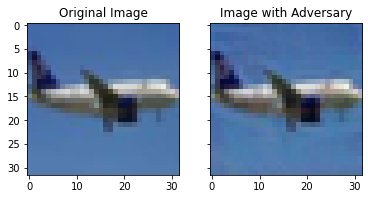

In [ ]:
# Comparing both images 
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image_test2)
ax1.set_title("Original Image")
ax2.imshow(image_test1_adv)
ax2.set_title("Image with Adversary")
plt.show()

original model prediction: 
airplane


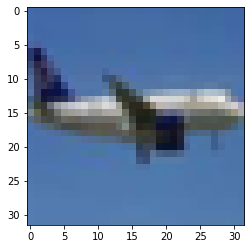

In [ ]:
plt.imshow(image_test2)
print(f'original model prediction: \n{label_names[model(image_test2.reshape(1,32,32,3)).numpy().argmax()]}')


after attack model prediction: 
ship


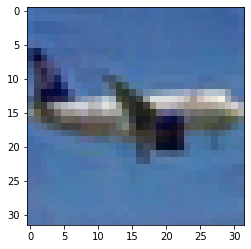

In [ ]:
plt.imshow(image_test1_adv)
print(f'after attack model prediction: \n{label_names[model(image_test1_adv.reshape(1,32,32,3)).numpy().argmax()]}')


### 3.2    Let's try this out for different values of epsilon and observe the resultant image.

In [ ]:
def display_images(image, image_label, image_labels, alphas, epsilons, model):
  '''Displays images with adversarial noise
  Args:
    image(np.array):  input image, shape like (height, width, channels)
    image_label(numpy.ndarray): label of the image, shape like (nb_classes, )
      array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)
    image_labels(list): list of labels of the images, shape like (nb_classes, )
    alphas(list): list of alpha parameters for I-FSGM
    epsilons(list): list of epsilon parameters for I-FSGM
    model(tf.keras.Model): model to be used for adversarial attack

  Examples:
      >>> display_images(train_images[0], train_labels[0], label_names, [0.1, 0.2, 0.3], [1, 3, 5], model)

  '''

  fix, axs = plt.subplots(len(alphas), len(epsilons), figsize=(20, 20))

  for i in range(len(alphas)):
    for j in range(len(epsilons)):
      adv_image = I_FSGM(image, image_label, alphas[i], epsilons[j])
      axs[i,j].imshow(adv_image)
      axs[i,j].set_title(f'alpha: {alphas[i]}, epsilon: {epsilons[j]}, {image_labels[model(adv_image.reshape(1,32,32,3)).numpy().argmax()]}', fontsize=7)
      axs[i,j].axis('off')


In [ ]:
#display_images(image_test1, image_test1_label, [0.1, 0.5, 1], [5, 10, 15])

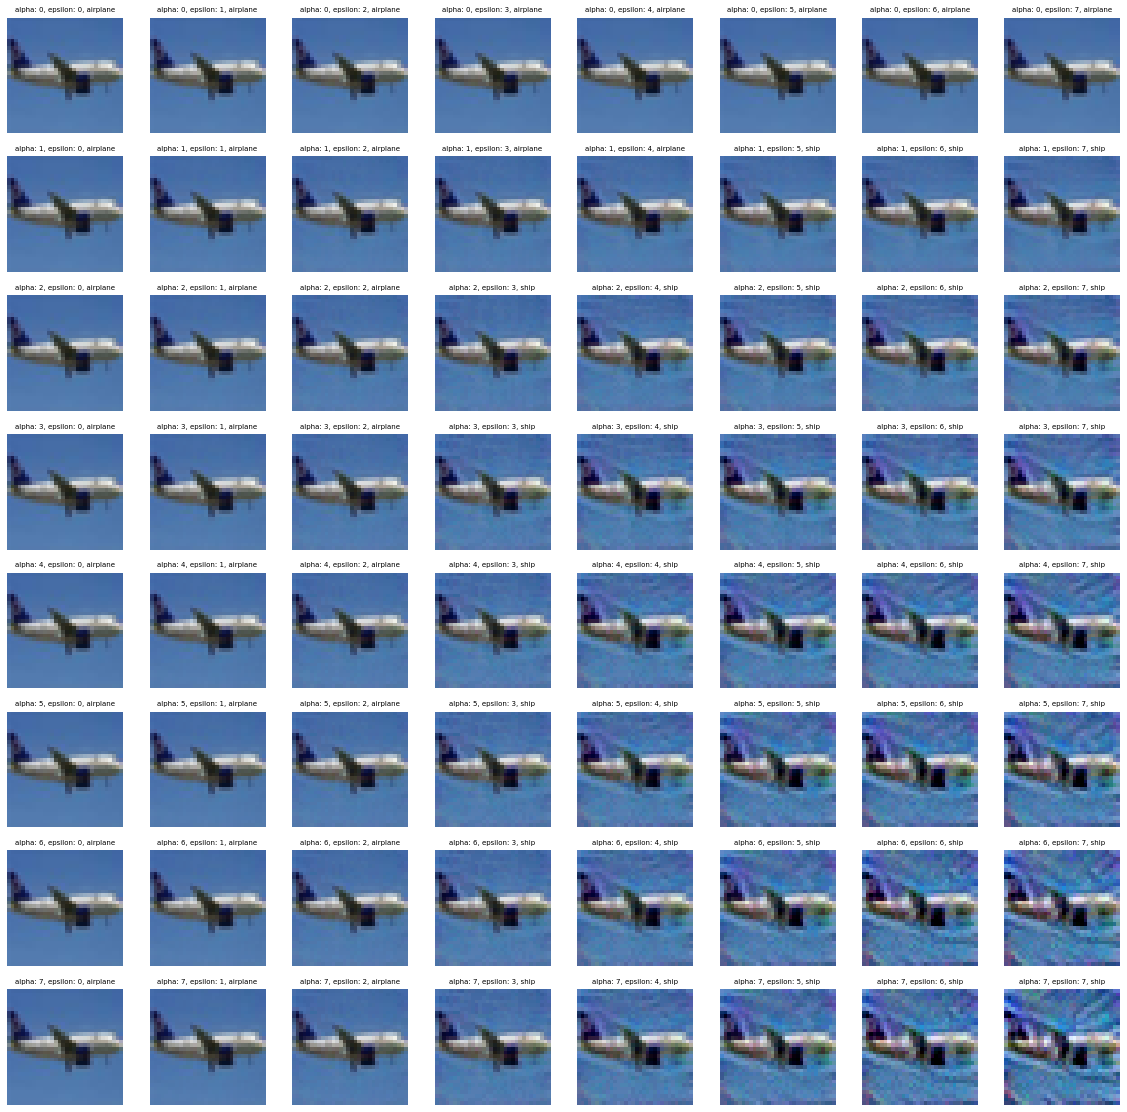

In [ ]:

alphas = [0, 1, 2, 3, 4, 5, 6, 7]
epsilons = [0, 1, 2, 3, 4, 5, 6, 7]
#descriptions_epsilon = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]
#descriptions_alpha = [('Alpha = {:0.3f}'.format(alpha) if alpha else 'Input') for alpha in alphas]

display_images(image_test2, image_test1_label, label_names, alphas, epsilons, model)

## 4    create a adversary noise set and test the model right rate

### 4.1 use 'map' function to calculate the accuracy

In [ ]:
def create_input_set(image_set, label_set, epsilon, alpha):
    '''Creates input set for map function
    Args:
        image_set(np.array): input image, shape like (nb_images, height, width, channels)
        label_set(np.array): input label, shape like (nb_images, nb_classes)
        epsilon(float): 
        alpha(float): 
        Parameters_I(int):

    Examples:
        >>> mage_and_label_list = create_input_set(test_images, test_labels, 0.2, 0.1, 1)

    Returns:   
        mage_and_label_list(list): list of tuples, each tuple contains (image, label, epsilon, alpha, Parameters_I) 


    '''

    image_and_label_list = []

    for i in range(len(image_set)):
        image_and_label_list.append([])
        image_and_label_list[i].append(image_set[i])
        image_and_label_list[i].append(label_set[i])
        image_and_label_list[i].append(epsilon)
        image_and_label_list[i].append(alpha)
    
    return image_and_label_list

In [ ]:
#image_and_label_list = create_input_set(test_images, test_labels, 3, 0.1)

In [ ]:
def predict_and_calculate_from_original(image_and_label_list):
    global model
    global label_names

    # get the original label
    original_label = np.where(image_and_label_list[1] == 1)[0][0] 


    # use adversarial image to get the predicted label
    prediction = model(image_and_label_list[0].reshape(1, 32, 32, 3))[0]
    prediction_label = prediction.numpy().argmax()

    if prediction_label == original_label:
        final_result = 1
    else:
        final_result = 0

    return final_result

In [ ]:
def predict_and_calculate_from_adv(image_and_label_list):
    global model
    global label_names

    # get the original label
    original_label = np.where(image_and_label_list[1] == 1)[0][0] 

    # get the adversarial image
    # I_FSGM(image, label, alpha, epsilon)
    image_adv = I_FSGM(image_and_label_list[0], image_and_label_list[1], image_and_label_list[3], image_and_label_list[2])
    # use adversarial image to get the predicted label
    prediction = model(image_adv.reshape(1, 32, 32, 3))[0]
    prediction_label = prediction.numpy().argmax()

    if prediction_label == original_label:
        final_result = 1
    else:
        final_result = 0

    return final_result

In [ ]:
#list(map(predict_and_calculate_from_original, image_and_label_list[:1000])).count(1)

In [ ]:
#list(map(predict_and_calculate_from_adv, image_and_label_list[:1000])).count(1)

#### 4.2.1 use test_image to test the function and calculate the accuracy

In [ ]:
def get_accuracy(image_set, image_label_set, epsilon, alpha):
    
    information_list = []

    total_num = len(image_set)

    start_time = time.time()

    # calculate the accuracy of the adversarial image
    # create_input_set(image_set, label_set, epsilon, alpha)
    image_and_label_adv_list = create_input_set(image_set, image_label_set, epsilon, alpha)

    right_num_adv = list(map(predict_and_calculate_from_adv, image_and_label_adv_list)).count(1)
    
    accuracy_adv = right_num_adv / total_num


    # calculate the accuracy of the original image
    right_num_original = list(map(predict_and_calculate_from_original, image_and_label_adv_list)).count(1)
    accuracy_original = right_num_original / total_num

    end_time = time.time()
    use_time = round(end_time - start_time, 2)

    # print the information
    print(f'epsilon: {epsilon}, alpha: {alpha}, accuracy_original: {accuracy_original}, accuracy_adv: {accuracy_adv}, use_time: {use_time}s')

    information_list.append(f'epsilon: {epsilon}, alpha: {alpha}, accuracy_original: {accuracy_original}, accuracy_adv: {accuracy_adv}, use_time: {use_time}s')

    return information_list

In [ ]:
epsilons = [1, 2, 3, 4, 5, 6, 7]
alphas = [1, 2, 3, 4, 5, 6, 7]

In [ ]:
for i, alpha in enumerate(alphas):
  for j, epsilon in enumerate(epsilons):
    result_information = get_accuracy(test_images, test_labels, epsilon, alpha)

    with open('information/ResNet.txt', 'a') as f:
        for item in result_information:
            f.write("%s\n" % item)

epsilon: 5, alpha: 7, accuracy_original: 0.419, accuracy_adv: 0.3003, use_time: 19599.95s
epsilon: 6, alpha: 7, accuracy_original: 0.419, accuracy_adv: 0.2732, use_time: 22117.46s
epsilon: 7, alpha: 7, accuracy_original: 0.419, accuracy_adv: 0.2493, use_time: 24981.53s
